# Installation 

! pip install fasterrisk

# FaskRisk

## Data-Processing

In [1]:
import os.path
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from fasterrisk.binarization_util import convert_continuous_df_to_binary_df
from fasterrisk.fasterrisk import RiskScoreOptimizer, RiskScoreClassifier
from fasterrisk.utils import download_file_from_google_drive

# -------------------------
# Config
# -------------------------
LABEL_COL = 'Cancer_lbl'
FEATURES_STLMD  = ['sct_long_dia','part_solid','ground_glass','solid','Upper_Lobe','Spiculation','age','sex']
FEATURES_STLM   = ['sct_long_dia','part_solid','ground_glass','solid','Upper_Lobe','Spiculation']
FEATURES_STPGLM = ['sct_long_dia','part_solid','ground_glass','Upper_Lobe','Spiculation']

CSV1 = 'ml_dataset/nlst_ct_nodule_df_set1.csv'
CSV2 = 'ml_dataset/nlst_ct_nodule_df_set2.csv'

# -------------------------
# Helpers
# -------------------------
def filter_and_report(df: pd.DataFrame) -> pd.DataFrame:
    initial_len = len(df)
    df = df[df['gender'].isin(['male', 'female'])]
    df = df[df['Nodule_Type'].isin(['solid', 'ground-glass', 'part-solid'])]
    print(f"[filter] Removed {initial_len - len(df)} rows (invalid gender or Nodule_Type).")
    return df

def to_fastrisk_y(y_raw, pos_label=1) -> np.ndarray:
    """Return 1-D np.ndarray[float] with labels in {-1.0, +1.0}."""
    y_arr = np.asarray(y_raw).ravel()
    uniq = set(np.unique(y_arr))
    if uniq <= {0, 1}:
        return (2 * y_arr - 1).astype(float)
    return np.where(y_arr == pos_label, 1.0, -1.0).astype(float)

def align_like_train(train_bin_df: pd.DataFrame, other_bin_df: pd.DataFrame) -> pd.DataFrame:
    """Make other_bin_df have exactly the same columns and order as train_bin_df."""
    cols = list(train_bin_df.columns)
    return other_bin_df.reindex(columns=cols, fill_value=0)

def prepare_data(df: pd.DataFrame, feature_cols, label_col):
    X = df[feature_cols]
    y = df[label_col]
    return X, y

def binarize_and_align(X_train_df: pd.DataFrame, X_val_df: pd.DataFrame, X_test_df: pd.DataFrame):
    """Binarize each split, then align val/test to training columns."""
    X_train_bin = convert_continuous_df_to_binary_df(X_train_df)
    X_val_bin   = convert_continuous_df_to_binary_df(X_val_df)
    X_test_bin  = convert_continuous_df_to_binary_df(X_test_df)
    X_val_bin   = align_like_train(X_train_bin, X_val_bin)
    X_test_bin  = align_like_train(X_train_bin, X_test_bin)
    # sanity
    assert list(X_val_bin.columns)  == list(X_train_bin.columns)
    assert list(X_test_bin.columns) == list(X_train_bin.columns)
    return X_train_bin, X_val_bin, X_test_bin

# -------------------------
# Load, filter, encode
# -------------------------
df1 = pd.read_csv(CSV1)
df2 = pd.read_csv(CSV2)

df1 = filter_and_report(df1)
df2 = filter_and_report(df2)

# Encode needed variables
for df in (df1, df2):
    df['sex'] = df['gender'].map({'male': 0, 'female': 1})
    df['part_solid']   = df['Nodule_Type'].apply(lambda x: 1 if 'part-solid'   in x else 0)
    df['ground_glass'] = df['Nodule_Type'].apply(lambda x: 1 if 'ground-glass' in x else 0)
    df['solid']        = df['Nodule_Type'].apply(lambda x: 1 if 'solid'        in x else 0)

# -------------------------
# Patient-level stratified split (on df1)
# -------------------------
patients = df1[['pid', LABEL_COL]].drop_duplicates()
train_patients, val_patients = train_test_split(
    patients,
    test_size=0.2,
    stratify=patients[LABEL_COL],
    random_state=42
)
train_df = df1[df1['pid'].isin(train_patients['pid'])]
val_df   = df1[df1['pid'].isin(val_patients['pid'])]

# ============================================================
# STLMD (includes age & sex)
# ============================================================
X_train_STLMD_df, y_train_STLMD_raw = prepare_data(train_df, FEATURES_STLMD, LABEL_COL)
X_val_STLMD_df,   y_val_STLMD_raw   = prepare_data(val_df,   FEATURES_STLMD, LABEL_COL)
X_test_STLMD_df,  y_test_STLMD_raw  = prepare_data(df2,      FEATURES_STLMD, LABEL_COL)

X_train_STLMD_bin, X_val_STLMD_bin, X_test_STLMD_bin = binarize_and_align(
    X_train_STLMD_df, X_val_STLMD_df, X_test_STLMD_df
)

y_train_STLMD = to_fastrisk_y(y_train_STLMD_raw, pos_label=1)
y_val_STLMD   = to_fastrisk_y(y_val_STLMD_raw,   pos_label=1)
y_test_STLMD  = to_fastrisk_y(y_test_STLMD_raw,  pos_label=1)

X_train_STLMD = X_train_STLMD_bin.to_numpy(dtype=float)
X_val_STLMD   = X_val_STLMD_bin.to_numpy(dtype=float)
X_test_STLMD  = X_test_STLMD_bin.to_numpy(dtype=float)

# ============================================================
# STLM (no age/sex)
# ============================================================
X_train_STLM_df, y_train_STLM_raw = prepare_data(train_df, FEATURES_STLM, LABEL_COL)
X_val_STLM_df,   y_val_STLM_raw   = prepare_data(val_df,   FEATURES_STLM, LABEL_COL)
X_test_STLM_df,  y_test_STLM_raw  = prepare_data(df2,      FEATURES_STLM, LABEL_COL)

X_train_STLM_bin, X_val_STLM_bin, X_test_STLM_bin = binarize_and_align(
    X_train_STLM_df, X_val_STLM_df, X_test_STLM_df
)

y_train_STLM = to_fastrisk_y(y_train_STLM_raw, pos_label=1)
y_val_STLM   = to_fastrisk_y(y_val_STLM_raw,   pos_label=1)
y_test_STLM  = to_fastrisk_y(y_test_STLM_raw,  pos_label=1)

X_train_STLM = X_train_STLM_bin.to_numpy(dtype=float)
X_val_STLM   = X_val_STLM_bin.to_numpy(dtype=float)
X_test_STLM  = X_test_STLM_bin.to_numpy(dtype=float)

# ============================================================
# STPGLM (subset features)
# ============================================================
X_train_STPGLM_df, y_train_STPGLM_raw = prepare_data(train_df, FEATURES_STPGLM, LABEL_COL)
X_val_STPGLM_df,   y_val_STPGLM_raw   = prepare_data(val_df,   FEATURES_STPGLM, LABEL_COL)
X_test_STPGLM_df,  y_test_STPGLM_raw  = prepare_data(df2,      FEATURES_STPGLM, LABEL_COL)

X_train_STPGLM_bin, X_val_STPGLM_bin, X_test_STPGLM_bin = binarize_and_align(
    X_train_STPGLM_df, X_val_STPGLM_df, X_test_STPGLM_df
)

y_train_STPGLM = to_fastrisk_y(y_train_STPGLM_raw, pos_label=1)
y_val_STPGLM   = to_fastrisk_y(y_val_STPGLM_raw,   pos_label=1)
y_test_STPGLM  = to_fastrisk_y(y_test_STPGLM_raw,  pos_label=1)

X_train_STPGLM = X_train_STPGLM_bin.to_numpy(dtype=float)
X_val_STPGLM   = X_val_STPGLM_bin.to_numpy(dtype=float)
X_test_STPGLM  = X_test_STPGLM_bin.to_numpy(dtype=float)

# -------------------------
# Quick hygiene checks
# -------------------------
def _chk(Xtr, ytr, Xv, yv, Xte, yte, name):
    assert Xtr.shape[0] == ytr.shape[0] and Xv.shape[0] == yv.shape[0] and Xte.shape[0] == yte.shape[0], f"row mismatch in {name}"
    assert set(np.unique(ytr)) <= {-1.0, 1.0} and set(np.unique(yv)) <= {-1.0, 1.0} and set(np.unique(yte)) <= {-1.0, 1.0}, f"bad labels in {name}"
    print(f"{name:7s} -> X_train {Xtr.shape}, X_val {Xv.shape}, X_test {Xte.shape}")

_chk(X_train_STLMD, y_train_STLMD, X_val_STLMD, y_val_STLMD, X_test_STLMD, y_test_STLMD, "STLMD")
_chk(X_train_STLM,  y_train_STLM,  X_val_STLM,  y_val_STLM,  X_test_STLM,  y_test_STLM,  "STLM")
_chk(X_train_STPGLM,y_train_STPGLM,X_val_STPGLM,y_val_STPGLM,X_test_STPGLM,y_test_STPGLM,"STPGLM")


[filter] Removed 0 rows (invalid gender or Nodule_Type).
[filter] Removed 0 rows (invalid gender or Nodule_Type).
Converting continuous features to binary features in the dataframe......
We select thresholds for each continuous feature by sampling (without replacement) <= max_num_thresholds_per_feature values from all unique values in that feature column.
Finish converting continuous features to binary features......
Converting continuous features to binary features in the dataframe......
We select thresholds for each continuous feature by sampling (without replacement) <= max_num_thresholds_per_feature values from all unique values in that feature column.
Finish converting continuous features to binary features......
Converting continuous features to binary features in the dataframe......
We select thresholds for each continuous feature by sampling (without replacement) <= max_num_thresholds_per_feature values from all unique values in that feature column.
Finish converting continuous

## FasterRisk Models

In [2]:

for RiskInputs in ["STLMD"]:#"STLM","STPGLM"]:
    
    
    print('Processing:{}'.format(RiskInputs))

    #-| Parameters
    sparsity    = 5
    parent_size = 10

    if RiskInputs == "STPGLM":
        X_train = X_train_STPGLM # X: ensure plain float np.array (not DataFrame)
        y_train = y_train_STPGLM # y: Series -> 1D float np.array in {-1,+1}
        X_test  = X_test_STPGLM # X: ensure plain float np.array (not DataFrame)
        y_test  = y_test_STPGLM # y: Series -> 1D float np.array in {-1,+1}
        X_train_bin = X_train_STPGLM_bin
    elif RiskInputs == "STLM":
        X_train = X_train_STLM # X: ensure plain float np.array (not DataFrame)
        y_train = y_train_STLM # y: Series -> 1D float np.array in {-1,+1}
        X_test  = X_test_STLM # X: ensure plain float np.array (not DataFrame)
        y_test  = y_test_STLM # y: Series -> 1D float np.array in {-1,+1}
        X_train_bin = X_train_STLM_bin
    elif RiskInputs == "STLMD":
        X_train = X_train_STLMD # X: ensure plain float np.array (not DataFrame)
        y_train = y_train_STLMD # y: Series -> 1D float np.array in {-1,+1}
        X_test  = X_test_STLMD # X: ensure plain float np.array (not DataFrame)
        y_test  = y_test_STLMD # y: Series -> 1D float np.array in {-1,+1}
        X_train_bin = X_train_STLMD_bin


    #-- Optimizer
    RiskScoreOptimizer_m = RiskScoreOptimizer(X = X_train, y = y_train, k = sparsity, parent_size = parent_size)
    start_time           = time.time()
    RiskScoreOptimizer_m.optimize()
    print("Optimization takes {:.2f} seconds.".format(time.time() - start_time))
    multipliers, sparseDiversePool_beta0_integer, sparseDiversePool_betas_integer = RiskScoreOptimizer_m.get_models()
    print("We generate {} risk score models from the sparse diverse pool".format(len(multipliers)))
    
    '''
    #-| Accessing First risk model
    model_index  = 1 # first model
    multiplier   = multipliers[model_index]
    intercept    = sparseDiversePool_beta0_integer[model_index]
    coefficients = sparseDiversePool_betas_integer[model_index]

    #-|Use the first risk score model to do prediction
    RiskScoreClassifier_m = RiskScoreClassifier(multiplier, intercept, coefficients, X_train = X_train)
    #- Apllying on test dataset
    y_test_pred           = RiskScoreClassifier_m.predict(X_test)
    print("y_test are predicted to be {}".format(y_test_pred))
    y_test_pred_prob = RiskScoreClassifier_m.predict_prob(X_test)
    print("The risk probabilities of having y_test to be +1 are {}".format(y_test_pred_prob))

    # Print the first model card
    X_featureNames      = X_train_bin.columns
    RiskScoreClassifier_m.reset_featureNames(X_featureNames)
    RiskScoreClassifier_m.print_model_card()
    '''
    top_10_probabilities = []
    X_featureNames       = X_train_bin.columns
    # Print Top 10 Model Cards from the Pool and their performance metrics
    num_models = min(10, len(multipliers))
    for model_index in range(num_models):
        multiplier = multipliers[model_index]
        intercept = sparseDiversePool_beta0_integer[model_index]
        coefficients = sparseDiversePool_betas_integer[model_index]

        RiskScoreClassifier_m = RiskScoreClassifier(multiplier, intercept, coefficients)
        RiskScoreClassifier_m.reset_featureNames(X_featureNames)
        RiskScoreClassifier_m.print_model_card()

        train_loss = RiskScoreClassifier_m.compute_logisticLoss(X_train, y_train)
        train_acc, train_auc = RiskScoreClassifier_m.get_acc_and_auc(X_train, y_train)
        test_acc, test_auc   = RiskScoreClassifier_m.get_acc_and_auc(X_test, y_test)
        y_test_pred_prob     = RiskScoreClassifier_m.predict_prob(X_test)
        top_10_probabilities.append(y_test_pred_prob)
        print("The logistic loss on the training set is {}".format(train_loss))
        print("The training accuracy and AUC are {:.3f}% and {:.3f}".format(train_acc*100, train_auc))
        print("The test accuracy and AUC are are {:.3f}% and {:.3f}\n".format(test_acc*100, test_auc))

Processing:STLMD
Optimization takes 791.56 seconds.
We generate 50 risk score models from the sparse diverse pool
The Risk Score is:
1.   sct_long_dia<=7.0     -2 point(s) |   ...
2.  sct_long_dia<=11.0     -2 point(s) | + ...
3.       Upper_Lobe<=0     -1 point(s) | + ...
4.           age<=56.0     -1 point(s) | + ...
5.           age<=73.0     -4 point(s) | + ...
                                 SCORE | =    
SCORE |  -10.0  |  -9.0  |  -8.0  |  -7.0  |  -6.0  |  -5.0  |
RISK  |   2.0% |   3.3% |   5.2% |   8.1% |  12.6% |  18.9% |
SCORE |  -4.0  |  -3.0  |  -2.0  |  -1.0  |   0.0  |
RISK  |  27.5% |  38.1% |  50.0% |  61.9% |  72.5% |
The logistic loss on the training set is 3045.616586186672
The training accuracy and AUC are 93.110% and 0.715
The test accuracy and AUC are are 92.603% and 0.692

The Risk Score is:
1.   sct_long_dia<=7.0     -2 point(s) |   ...
2.  sct_long_dia<=10.0     -2 point(s) | + ...
3.      Spiculation<=0     -2 point(s) | + ...
4.           age<=56.0     -2 

# AUC analysis 

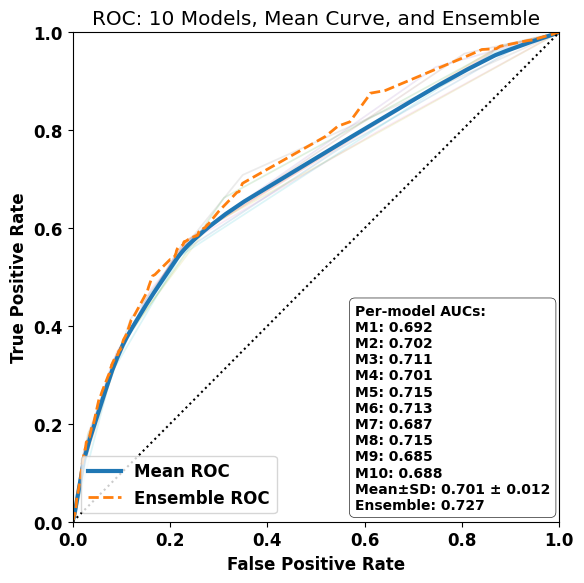

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from scipy import interpolate

plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams.update({'font.size':12})

# y_test_STLMD_raw: 1D labels (0/1)
y = np.asarray(y_test_STLMD_raw).astype(int).ravel()

# --- Convert your "list of 10 lists" into (n_models, n_samples)
probs = np.vstack([np.asarray(p).ravel() for p in top_10_probabilities])
assert probs.ndim == 2 and probs.shape[1] == y.shape[0], \
    f"Mismatch: probs has {probs.shape[1]} samples, y has {y.shape[0]}."

# ---- Per-model ROC & AUC ----
fpr_grid = np.linspace(0, 1, 2001)
tpr_on_grid, aucs, curves = [], [], []

for p in probs:
    fpr, tpr, _ = roc_curve(y, p)
    aucs.append(roc_auc_score(y, p))
    order = np.argsort(fpr)
    fpr, tpr = fpr[order], tpr[order]
    f = interpolate.interp1d(fpr, tpr, kind="linear", bounds_error=False, fill_value=(0.0, 1.0))
    tpr_on_grid.append(f(fpr_grid))
    curves.append((fpr, tpr))

aucs = np.array(aucs, float)
mean_auc = aucs.mean()
std_auc  = aucs.std(ddof=1) if len(aucs) > 1 else 0.0

# ---- Mean curve (macro-average) ----
tpr_on_grid = np.vstack(tpr_on_grid)
mean_tpr = tpr_on_grid.mean(axis=0)
mean_curve_auc = np.trapz(mean_tpr, fpr_grid)

# ---- Ensemble (average probs first) ----
ensemble_probs = probs.mean(axis=0)          # works now because it's a NumPy array
fpr_e, tpr_e, _ = roc_curve(y, ensemble_probs)
ensemble_auc = roc_auc_score(y, ensemble_probs)

# ---- Plot ----
plt.figure(figsize=(6, 6))
for fpr, tpr in curves:
    plt.plot(fpr, tpr, linewidth=1.25, alpha=0.15)

plt.plot(fpr_grid, mean_tpr, linewidth=3.0, label=f"Mean ROC")
plt.plot(fpr_e, tpr_e, linestyle="--", linewidth=2.0, label=f"Ensemble ROC")
plt.plot([0, 1], [0, 1], linestyle=":", linewidth=1.5, color='black')

plt.xlim(0, 1); plt.ylim(0, 1)
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC: 10 Models, Mean Curve, and Ensemble")

txt = "Per-model AUCs:\n" + "\n".join([f"M{i+1}: {a:.3f}" for i, a in enumerate(aucs)]) \
      + f"\nMean±SD: {mean_auc:.3f} ± {std_auc:.3f}\nEnsemble: {ensemble_auc:.3f}"
plt.gca().text(0.58, 0.02, txt, transform=plt.gca().transAxes,
               fontsize=10, va="bottom", ha="left",
               bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.85, linewidth=0.5))

plt.legend(loc="lower left")
plt.tight_layout()
plt.show()


Key Takeways:

* Stable rules: Models learned on nodule size (≤7 & ≤10/11 mm), absence of spiculation, non–upper-lobe, and younger age (≈56–58, 68, 73) as protective cutoffs. Sex didn’t matter.

* Single-model performance: Per-model test AUCs span 0.685–0.715 (mean 0.701 ± 0.012). Train accuracy ≈ 93%, test ≈ 92.6% across cards (accuracy is high mainly due to class balance—AUC is the discriminative signal).